In [79]:
import cv2
import glob
from matplotlib import pyplot as plt
import numpy as np
from pathlib import Path

In [80]:
# Directory containing the images within the "images" diretory
IMAGES_PATH = "samples"

# Format of the images
IMAGES_FORMAT = "jpg"

# Dimensions of the chessboard used (There are some weird chessboards)
CHESSBOARD_SIZE = (7, 6)

# Whether to retain all the pixels of the image after undistorting.
# Retaining the pixels would mean that the edges/corners of the image
# will have some black pixels.
RETAIN_PIXELS = True

In [81]:
# Returns the number of successes
def successes(results):
    return list(filter(lambda result: result is not None, results))

In [82]:
# Create the `Path` object
path = Path("images") / Path(IMAGES_PATH) / Path(f"*.{IMAGES_FORMAT}")
img_paths = glob.glob(str(path))

# Store the loaded images here, with `None` representing failure.
imgs = []

# Load the images
for img_path in img_paths:
    img = cv2.imread(img_path)
    if img is None:
        print(f"Failed to load image at {img_path}!")
    else:
        print(f"Loaded image at {img_path}...")
    imgs.append(img)
    
print(f"Done! {len(successes(imgs))} images found.")

Loaded image at images/samples/left09.jpg...
Loaded image at images/samples/left08.jpg...
Loaded image at images/samples/left14.jpg...
Loaded image at images/samples/left01.jpg...
Loaded image at images/samples/left03.jpg...
Loaded image at images/samples/left02.jpg...
Loaded image at images/samples/left12.jpg...
Loaded image at images/samples/left06.jpg...
Loaded image at images/samples/left07.jpg...
Loaded image at images/samples/left13.jpg...
Loaded image at images/samples/left05.jpg...
Loaded image at images/samples/left11.jpg...
Loaded image at images/samples/left04.jpg...
Done! 13 images found.


Failed to find corners for images/samples/left09.jpg :(
Successfully found corners for images/samples/left08.jpg!


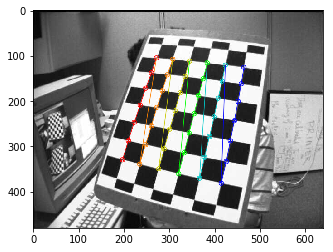

Successfully found corners for images/samples/left14.jpg!


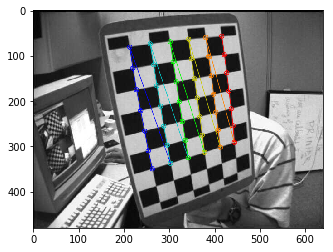

Successfully found corners for images/samples/left01.jpg!


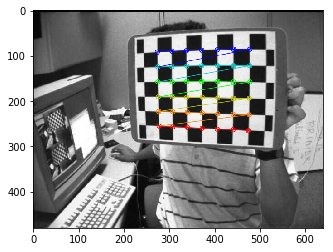

Successfully found corners for images/samples/left03.jpg!


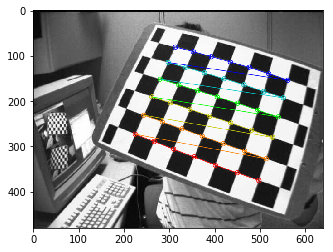

Successfully found corners for images/samples/left02.jpg!


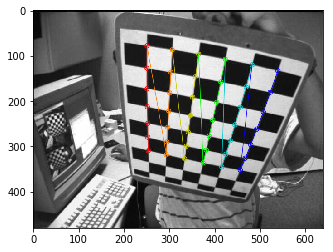

Successfully found corners for images/samples/left12.jpg!


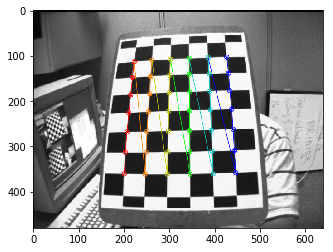

Successfully found corners for images/samples/left06.jpg!


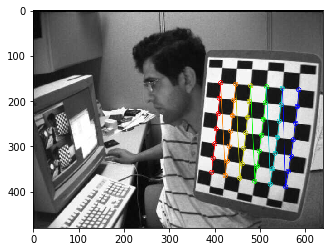

Successfully found corners for images/samples/left07.jpg!


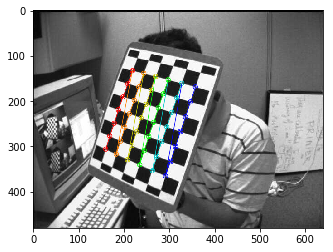

Successfully found corners for images/samples/left13.jpg!


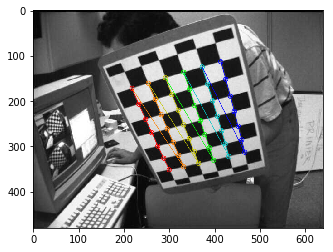

Successfully found corners for images/samples/left05.jpg!


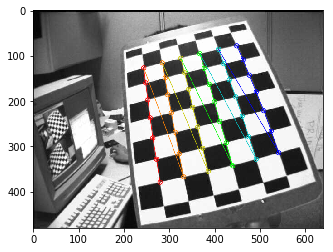

Failed to find corners for images/samples/left11.jpg :(
Successfully found corners for images/samples/left04.jpg!


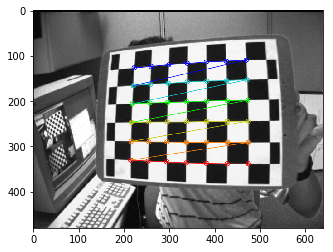

Done! 11 chessboard corners found.


In [83]:
# Termination criteria
TERM_CRITERIA = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)

# Create object points
OBJECT_POINTS = np.zeros((6*7,3), np.float32)
OBJECT_POINTS[:,:2] = np.mgrid[0:7,0:6].T.reshape(-1,2)

# Store the resulting object and image points here, with `None` indicating failure.
obj_points = []
img_points = []

# Find all the chessboard corners.
for (i, img) in enumerate(imgs):
    # Skip those that failed to load
    if img is None:
        continue
        
    # Convert the image to grayscale
    gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray_img, CHESSBOARD_SIZE, None)
    
    if ret:
        print(f"Successfully found corners for {img_paths[i]}!")
        
        # Further increase the accuracy of the corners
        cv2.cornerSubPix(gray_img, corners, (11, 11), (-1, -1), TERM_CRITERIA)
        
        # Append `corners` to the list of corners.
        obj_points.append(OBJECT_POINTS)
        img_points.append(corners)
        
        # Display the image with the corners
        show_img = img.copy()
        cv2.drawChessboardCorners(show_img, CHESSBOARD_SIZE, corners, ret)
        show_img = cv2.cvtColor(show_img, cv2.COLOR_BGR2RGB)
        plt.imshow(show_img)
        plt.show()
    else:
        print(f"Failed to find corners for {img_paths[i]} :(")
        
        # Append `None`, which indicates a failure.
        img_points.append(None)
        
print(f"Done! {len(successes(img_points))} chessboard corners found.")

In [84]:
# Warn if not enough success cases
if len(successes(img_points)) < 10:
    print("Careful! There are less than 10 successful cases.")
    print("The results might not be optimal with this few cases.")

# Filter out the failure cases
obj_points = successes(obj_points)
img_points = successes(img_points)

# Calculate the camera calibration
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(obj_points, img_points, gray_img.shape[::-1], None, None)

print("Done! Calibrated the camera matrix.")

Done! Calibrated the camera matrix.


Undistoring image at images/samples/left09.jpg...


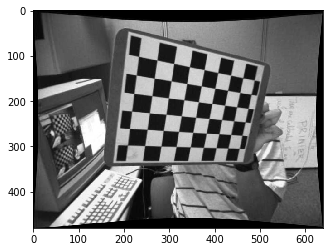

Undistoring image at images/samples/left08.jpg...


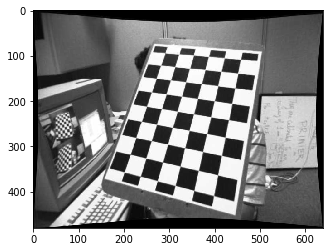

Undistoring image at images/samples/left14.jpg...


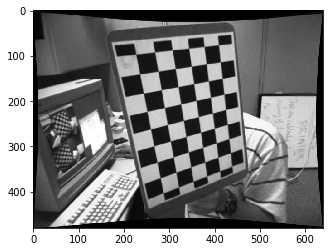

Undistoring image at images/samples/left01.jpg...


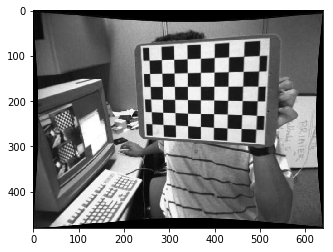

Undistoring image at images/samples/left03.jpg...


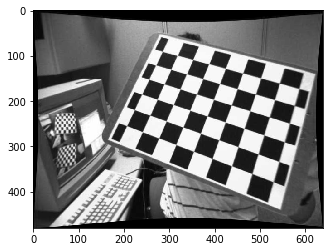

Undistoring image at images/samples/left02.jpg...


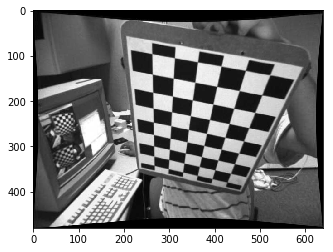

Undistoring image at images/samples/left12.jpg...


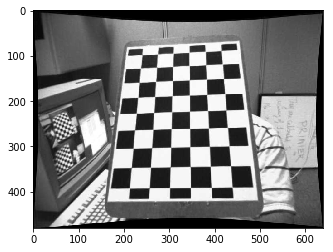

Undistoring image at images/samples/left06.jpg...


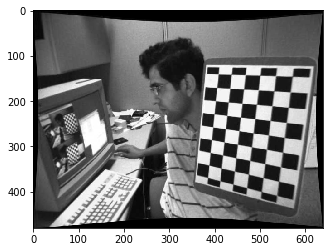

Undistoring image at images/samples/left07.jpg...


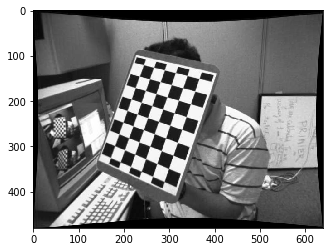

Undistoring image at images/samples/left13.jpg...


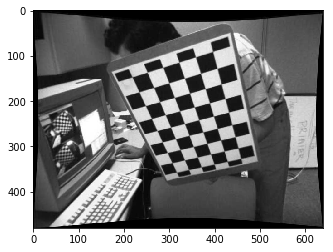

Undistoring image at images/samples/left05.jpg...


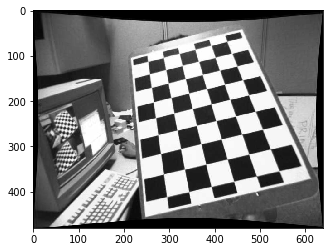

Undistoring image at images/samples/left11.jpg...


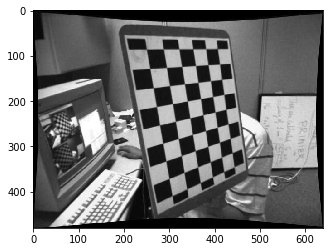

Undistoring image at images/samples/left04.jpg...


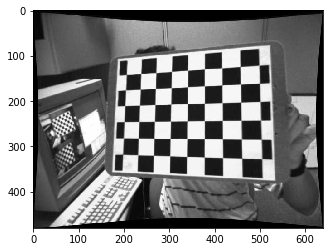

Done! 13 images undistorted.


In [87]:
# Change the `RETAIN_PIXELS` bool into either 1 or 0
alpha = 0
if RETAIN_PIXELS:
    alpha = 1

# Undistort all the images
for (i, img) in enumerate(imgs):
    # Skip those that failed to load
    if img is None:
        continue
        
    # Get the shape of the image
    h, w = img.shape[:2]
    
    # Recalculate the camera matrix based on `RETAIN_PIXELS`
    undist_mtx, _ = cv2.getOptimalNewCameraMatrix(mtx, dist, (w, h), alpha, (w, h))
    
    # Undistort the image
    print(f"Undistoring image at {img_paths[i]}...")
    undst_img = cv2.undistort(img, mtx, dist, None, undist_mtx)
    
    # Display the undistorted image
    show_img = cv2.cvtColor(undst_img, cv2.COLOR_BGR2RGB)
    plt.imshow(show_img)
    plt.show()

    
print(f"Done! {len(successes(imgs))} images undistorted.")

In [89]:
# Store the total error here.
total_error = 0

for i in range(len(obj_points)):
    # Skip failures
    if obj_points[i] is None:
        continue
        
    # Calculate the projection error
    proj_img_points, _ = cv2.projectPoints(obj_points[i], rvecs[i], tvecs[i], mtx, dist)
    error = cv2.norm(img_points[i], proj_img_points, cv2.NORM_L2) / len(proj_img_points)
    total_error += error

# Caculate the mean error
mean_error = total_error / len(successes(obj_points))

print(f"Done! The average error is {mean_error}.")

Done! The average error is 0.023686000375385673.
